## 大作业-6-fcm of lda


### 声明
这节内容参考了下面这个比的工作

https://blog.csdn.net/qq_43647936/article/details/130686246

https://github.com/helloWorldchn/MachineLearning/tree/main

## 导入库

In [63]:
from pylab import *
import pandas as pd
import numpy as np
import operator
import math
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import normalized_mutual_info_score  # NMI
from sklearn.metrics import rand_score  # RI
from sklearn.metrics import accuracy_score  # ACC
from sklearn.metrics import f1_score  # F-measure
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


## 数据导入及标准化

In [64]:
k = 3  # 聚类簇数
MAX_ITER = 200  # 最大迭代数
m = 2.00  # 模糊参数

In [65]:
df_lda = pd.read_csv('data_lda.csv')
X_lda = df_lda.drop(['age'], axis = 1)
y_lda = df_lda['age']
X_train, X_test, y_train, y_test = train_test_split(X_lda, y_lda, test_size = 0.33, random_state = 123)
df_lda = pd.concat([X_test, y_test], axis=1)
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_train)
X_test1 = scaler.transform(X_test)

y_train = y_train.values.tolist()
y_test = y_test.values.tolist()
X_train = pd.DataFrame(X_train1, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test1, columns=X_test.columns, index=X_test.index)  

## copy了别人的工作

In [66]:

# 初始化模糊矩阵U
def initializeMembershipMatrix():
    membership_mat = list()
    for i in range(n):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x / summation for x in random_num_list]  # 首先归一化
        membership_mat.append(temp_list)
    return membership_mat


# 计算类中心点
def calculateClusterCenter(membership_mat, data_name):
    dataname = data_name
    cluster_mem_val = zip(*membership_mat)
    cluster_centers = list()
    cluster_mem_val_list = list(cluster_mem_val)
    for j in range(k):
        x = cluster_mem_val_list[j]
        x_raised = [e ** m for e in x]
        denominator = sum(x_raised)
        temp_num = list()
        for i in range(n):
            data_point = list(dataname.iloc[i])
            prod = [x_raised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z / denominator for z in numerator]  # 每一维都要计算。
        cluster_centers.append(center)
    return cluster_centers


# 更新隶属度
def updateMembershipValue(membership_mat, cluster_centers, data_name):
    #    p = float(2/(m-1))
    dataname = data_name
    data = []
    for i in range(n):
        x = list(dataname.iloc[i])  # 取出文件中的每一行数据
        data.append(x)
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j] / distances[c]), 2) for c in range(k)])
            membership_mat[i][j] = float(1 / den)
    return membership_mat, data


# 得到聚类结果
def getClusters(membership_mat):
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels


def fuzzyCMeansClustering(data_name):
    # 主程序
    dataname = data_name
    membership_mat = initializeMembershipMatrix()
    curr = 0
    start = time.time()  # 开始时间，计时
    while curr <= MAX_ITER:  # 最大迭代次数
        cluster_centers = calculateClusterCenter(membership_mat, data_name) # 计算类中心
        membership_mat, data = updateMembershipValue(membership_mat, cluster_centers, data_name)    # 更新隶属度
        cluster_labels = getClusters(membership_mat)    # 得到聚类结果
        curr += 1

    print("用时：{0}".format(time.time() - start))
    # print(membership_mat)
    return cluster_labels, cluster_centers, data, membership_mat




def clustering_indicators(labels_true, labels_pred):
    if type(labels_true[0]) != int:
        labels_true = LabelEncoder().fit_transform(df[columns[len(columns) - 1]])  # 如果标签为文本类型，把文本标签转换为数字标签
    f_measure = f1_score(labels_true, labels_pred, average='macro')  # F值
    accuracy = accuracy_score(labels_true, labels_pred)  # ACC
    normalized_mutual_information = normalized_mutual_info_score(labels_true, labels_pred)  # NMI
    rand_index = rand_score(labels_true, labels_pred)  # RI
    return f_measure, accuracy, normalized_mutual_information, rand_index



## fcm

In [67]:
n = len(X_train)
y_train_pred, centers, data, membership = fuzzyCMeansClustering(X_train)
F_measure, ACC, NMI, RI = clustering_indicators(y_train, y_train_pred)
print("F_measure:", F_measure, "ACC:", ACC, "NMI", NMI, "RI", RI)

用时：46.46840524673462
F_measure: 0.1767334612703376 ACC: 0.22104866088268577 NMI 0.26756493264784004 RI 0.627275147149883


In [68]:
n = len(X_test)
cluster_centers = calculateClusterCenter(membership, X_test)
membership, data = updateMembershipValue(membership, cluster_centers, X_test)
y_test_pred = getClusters(membership)

F_measure, ACC, NMI, RI = clustering_indicators(y_test, y_test_pred)
print("F_measure:", F_measure, "ACC:", ACC, "NMI", NMI, "RI", RI)


F_measure: 0.21751208983261924 ACC: 0.2823259372609028 NMI 0.20483055368476885 RI 0.5616136927909677


本文选择了F值（F-measure，FM）、准确率（Accuracy，ACC）、标准互信息（Normalized Mutual Information，NMI）和兰德指数（Rand Index，RI）作为评估指标，其值域为[0,1]，取值越大说明聚类结果越符合预期。

F值结合了精度（Precision）与召回率（Recall）两种指标，它的值为精度与召回率的调和平均，其计算公式见公式：
### F值（F-measure, FM）
$$ F = \frac{2 \times Precision \times Recall}{Precision + Recall} = \frac{2 \times \frac{TP}{TP+FP} \times \frac{TP}{TP+FN}}{\frac{TP}{TP+FP} + \frac{TP}{TP+FN}} $$

其中TP表示真正例，FP表示假正例，FN表示假反例。值的范围在0到1之间，F值越大表示模型性能越好。

### 准确率（Accuracy, ACC）
$$ Accuracy = \frac{TP + TN}{TP + TN + FP + FN} $$

其中TN表示真反例。

### 标准互信息（Normalized Mutual Information, NMI）
NMI 的公式较为复杂，基于熵的概念，但其基本形式可以简化表示为：
$$ NMI(X,Y) = \frac{I(X;Y)}{\sqrt{H(X)H(Y)}} $$
其中I(X;Y)是互信息，H(X)和H(Y)分别是X和Y的熵。
NMI通常用于聚类算法的性能评估，它衡量两个标签集（如真实标签和预测标签）之间的相似性，范围在0到1之间，值越大表示两个标签集越相似。NMI通过归一化互信息来实现，以确保即使在不同大小的数据集上也能进行比较。
### 兰德指数（Rand Index, RI）
兰德指数的计算涉及比较每一对样本的聚类结果，其公式为：
$$ RI = \frac{a + b}{\binom{n}{2}} $$
这里a是在两个聚类中都被正确地放在同一个簇中的样本对数量，b是在两个聚类中都被正确地放在不同簇中的样本对数量，而n是样本总数。
兰德指数同样用于评估聚类算法的性能，它衡量的是两个数据点对（即同一类或不同类的数据点对）的匹配程度。RI的取值范围也是0到1，1表示完全匹配，0表示没有匹配。RI不考虑聚类的数量和大小，只关注数据点是否被正确地分在同一组或不同组。

## 可视化

In [69]:
# print(centers)
center_array = array(centers)
label = array(y_test_pred)
datas = array(X_test)
label_1 = array(y_test)


In [70]:
print(label_1 )
print(label )


[1 0 1 ... 1 1 0]
[0 2 0 ... 1 2 2]


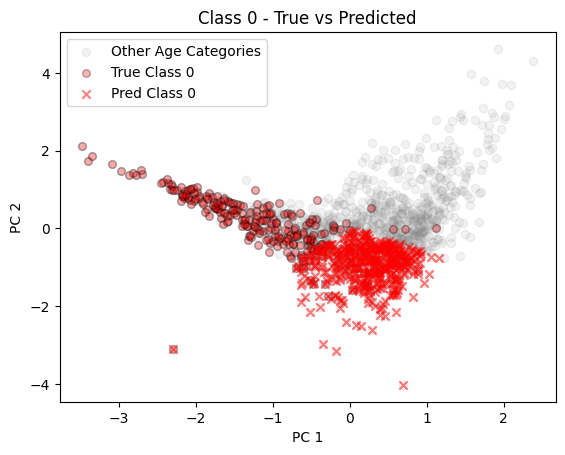

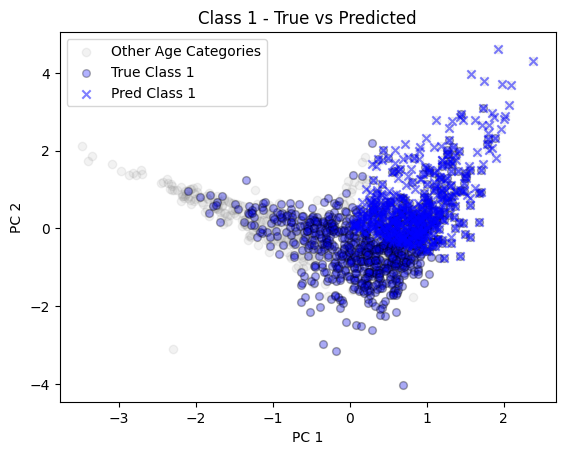

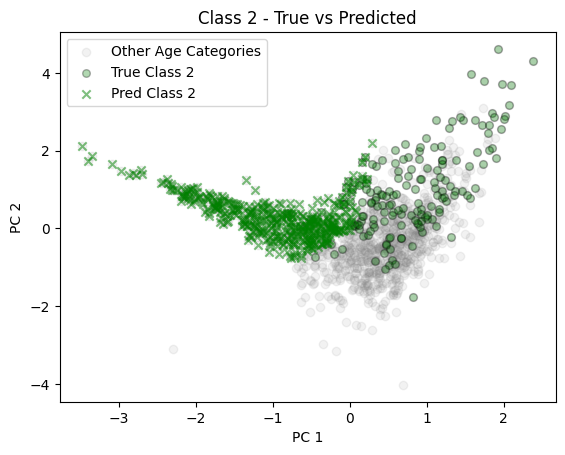

In [71]:
X_test = X_test.values
# 同样的假设条件
categories = [0, 1, 2]
colors = ['red', 'blue', 'green']

# 对于每个类别，单独创建并显示图表
for idx, category in enumerate(categories):
    # 创建新的图表
    plt.figure(figsize=(6.4, 4.8))
    
    # 选择当前类别的样本
    mask_true = label_1 == category
    mask_pred = label == category

    plt.scatter(X_test[:, 0], X_test[:, 1],
                   c='gray', 
                   alpha=0.1, 
                   label='Other Age Categories',
                   zorder=1)
    
    plt.scatter(X_test[mask_true, 0], X_test[mask_true, 1], 
                 c=colors[idx], marker='o', edgecolors='black', s=30,
                 label=f'True Class {category}', alpha=0.3,zorder=2)
    
    
    plt.scatter(X_test[mask_pred, 0], X_test[mask_pred, 1], 
                 c=colors[idx], marker='x', label=f'Pred Class {category}',
                 alpha=0.5, zorder=3)
    
    
    plt.title(f'Class {category} - True vs Predicted')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend()


plt.show()

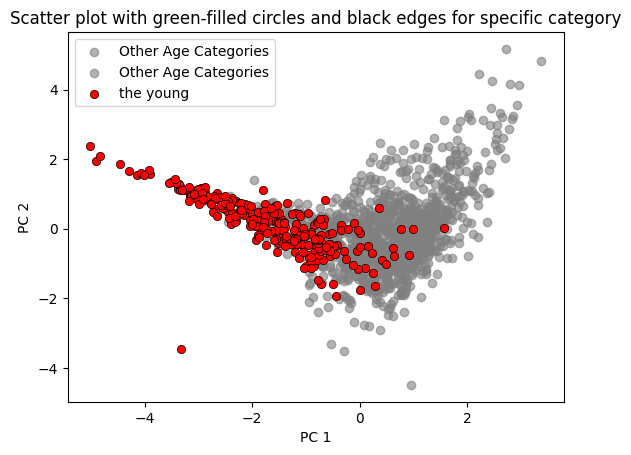

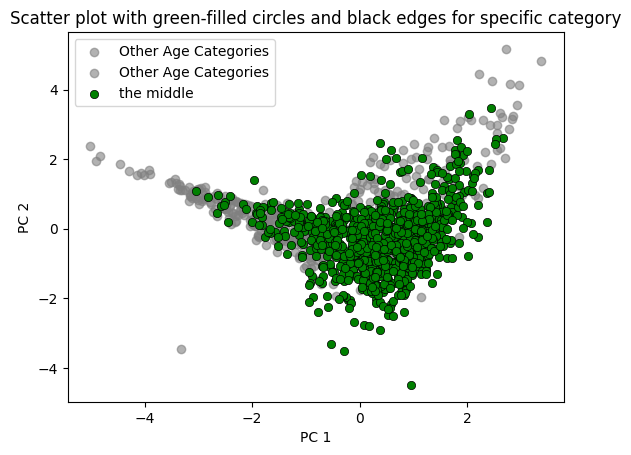

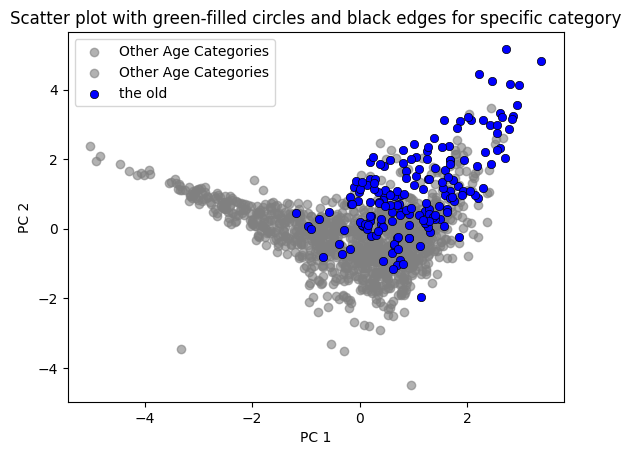

In [72]:
for category in df_lda['age'].unique():
    if category != 0:
        subset = df_lda[df_lda['age'] == category]
        plt.scatter(subset['PC 1'], subset['PC 2'], 
                   c='gray', 
                   alpha=0.6, 
                   label='Other Age Categories',
                   zorder=1)  

subset_green = df_lda[df_lda['age'] == 0]
plt.scatter(subset_green['PC 1'], subset_green['PC 2'], 
            c='red',  
            edgecolors='black',  
            linewidth=0.5,  
            alpha=1.0,  
            label='the young',
            zorder=2)

plt.legend()

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Scatter plot with green-filled circles and black edges for specific category')
plt.show()
for category in df_lda['age'].unique():
    if category != 1:
        subset = df_lda[df_lda['age'] == category]
        plt.scatter(subset['PC 1'], subset['PC 2'], 
                   c='gray', 
                   alpha=0.6, 
                   label='Other Age Categories',
                   zorder=1)  

subset_green = df_lda[df_lda['age'] == 1]
plt.scatter(subset_green['PC 1'], subset_green['PC 2'], 
            c='green',  
            edgecolors='black',  
            linewidth=0.5,  
            alpha=1.0,  
            label='the middle',
            zorder=2)  

plt.legend()

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Scatter plot with green-filled circles and black edges for specific category')
plt.show()
for category in df_lda['age'].unique():
    if category != 2:
        subset = df_lda[df_lda['age'] == category]
        plt.scatter(subset['PC 1'], subset['PC 2'], 
                   c='gray', 
                   alpha=0.6, 
                   label='Other Age Categories',
                   zorder=1)  

subset_green = df_lda[df_lda['age'] == 2]
plt.scatter(subset_green['PC 1'], subset_green['PC 2'], 
            c='blue',  
            edgecolors='black',  
            linewidth=0.5,  
            alpha=1.0,  
            label='the old',
            zorder=2)

plt.legend()

plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Scatter plot with green-filled circles and black edges for specific category')
plt.show()